In [22]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
log = "benchmark.log"

# Initialize variables
records = []
current_benchmark = ""
current_N = 0
current_R = 0
current_result = 0.0

In [3]:
# Process each line
for line in open(log, 'r'):
    line = line.strip()
    if 'Bechmarking' in line:
        current_benchmark = line.split()[1].strip(':')
    elif 'N =' in line:
        parts = line.split(',')
        current_N = int(parts[0].split('=')[1].strip())
        current_R = int(parts[1].split('=')[1].strip(':'))
    elif 'Result:' in line:
        current_result = float(line.split(':')[1].strip())
    elif 'N:' in line:
        t_val = float(re.search(r'<T>: (.*?) sec', line).group(1))
        b_val = float(re.search(r'B: (.*?) GB/sec', line).group(1))
        f_val = float(re.search(r'F: (.*?) FLOP/sec', line).group(1))
        record = {
            'Benchmark': current_benchmark,
            'N': current_N,
            'R': current_R,
            'Result': current_result,
            'Time (sec)': t_val,
            'Bandwidth (GB/sec)': b_val,
            'FLOP/sec': f_val
        }
        records.append(record)

# Create DataFrame
df = pd.DataFrame(records)

# Deduplicate by N and R
df = df.drop_duplicates(subset=['N', 'R', 'Benchmark']).reset_index(drop=True)

# Display DataFrame
df

,Benchmark,N,R,Result,Time (sec),Bandwidth (GB/sec),FLOP/sec
0,dp1,1000000,1000,1000000.0,0.000004,1974.354,5.299866e+11
1,dp1,300000000,20,16777216.0,0.057298,39.009,1.047150e+10
2,dp2,1000000,1000,1000000.0,0.000001,6591.719,1.769451e+12
3,dp2,300000000,20,67108864.0,0.024240,92.211,2.475261e+10
4,dp3,1000000,1000,1000000.0,0.000031,237.220,6.367838e+10
5,dp3,300000000,20,300000000.0,0.012260,182.316,4.894011e+10
6,dp4,1000000,1000,300000000.0,0.185137,0.040,1.080283e+07
7,dp4,300000000,20,300000000.0,55.489740,0.040,1.081281e+07
8,dp5,1000000,1000,300000000.0,0.000113,65.945,1.770189e+10
9,dp5,300000000,20,300000000.0,0.090070,24.816,6.661522e+09


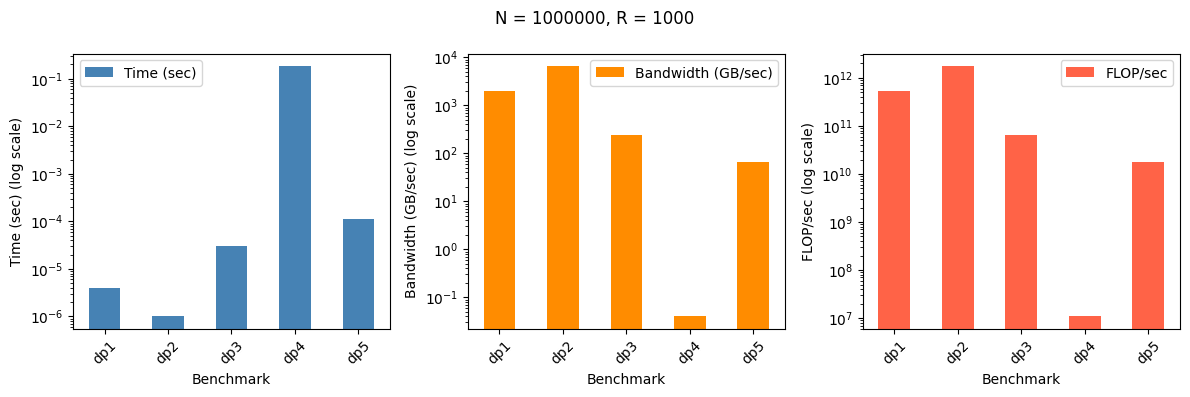

In [4]:
# visualize for benchmark
cols = ['Time (sec)', 'Bandwidth (GB/sec)', 'FLOP/sec']
colors = ["steelblue", "darkorange", "tomato"]

def vis(N, R):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i, ax in enumerate(axs.flatten()):
        sub_df = df.query(f'N == {N} and R == {R}')
        sub_df.plot(x='Benchmark', y=cols[i], kind='bar', ax=ax, color=colors[i])
        ax.set_yscale('log')
        ax.set_ylabel(cols[i] + ' (log scale)')
        ax.set_xticklabels(sub_df['Benchmark'], rotation=45)
    plt.suptitle(f"N = {N}, R = {R}")
    plt.tight_layout()
    plt.show()

vis(1000000, 1000)

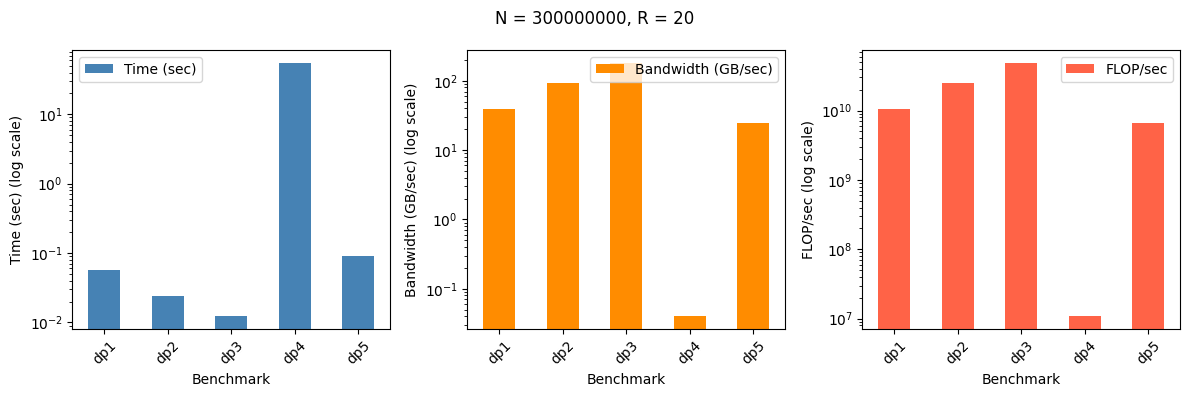

In [5]:
vis(300000000, 20)

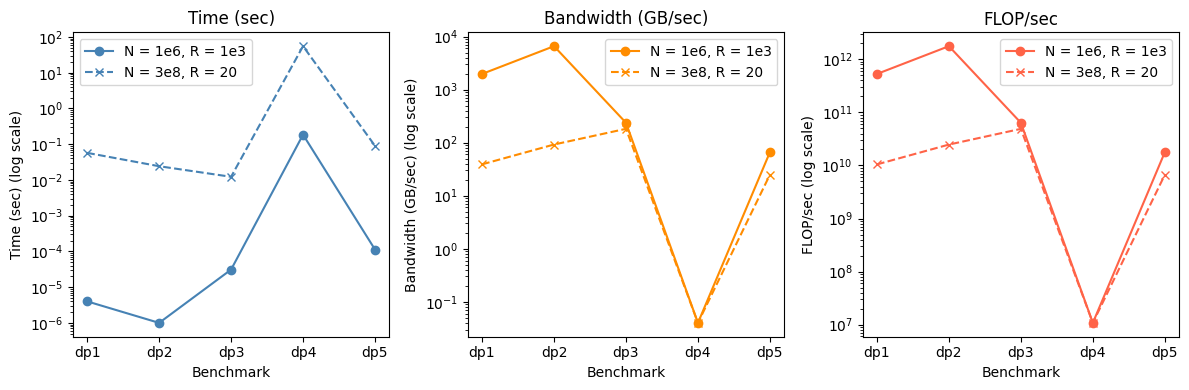

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axs.flatten()):
    sub_df1 = df.query(f'N == 1000000 and R == 1000')
    sub_df2 = df.query(f'N == 300000000 and R == 20')
    sub_df1.plot(x='Benchmark', y=cols[i], kind='line', ax=ax, color=colors[i], marker='o')
    sub_df2.plot(x='Benchmark', y=cols[i], kind='line', ax=ax, color=colors[i], linestyle='--', marker='x')
    ax.set_title(cols[i])
    ax.set_yscale('log')
    ax.set_ylabel(cols[i] + ' (log scale)')
    ax.legend(['N = 1e6, R = 1e3', 'N = 3e8, R = 20'])
plt.tight_layout()
plt.show()


### Roofline Plot

In [20]:
BANDWIDTH = 30  # GB/s
MAX_FLOPS = 200  # GFLOPS
ARITHMETIC_INTENSITY_CUTOFF = MAX_FLOPS / BANDWIDTH  # FLOP/Byte


In [16]:
2 ** 30

1073741824

In [21]:
df['arithmetic_intensity'] = 2 * df['N'] / (2 * df['N'] * 4)  # FLOP/Byte
slope = BANDWIDTH * 2**30

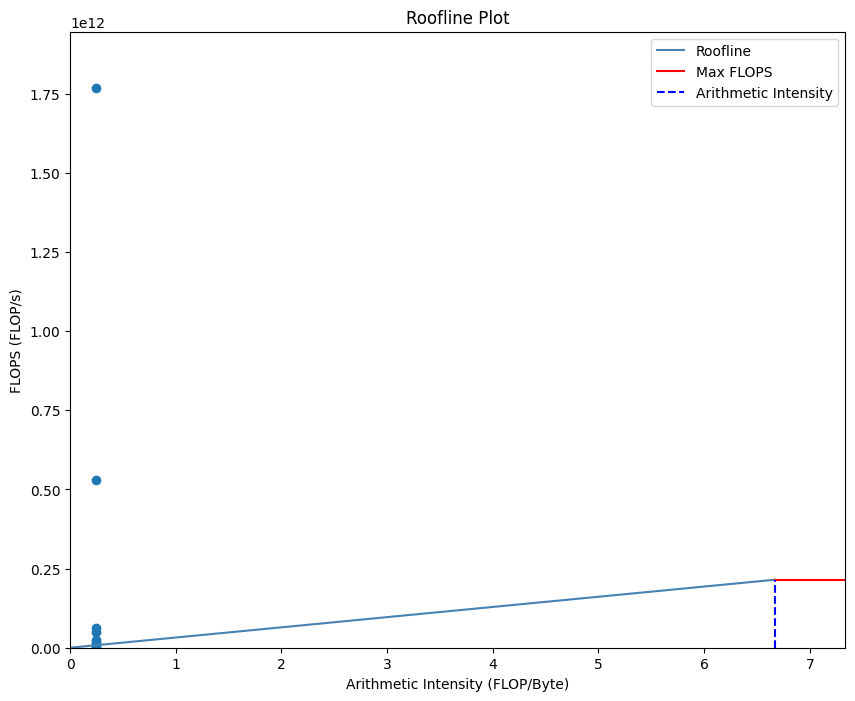

In [36]:
x = np.linspace(0, ARITHMETIC_INTENSITY_CUTOFF, 100)
intercept = MAX_FLOPS * 2**30 - ARITHMETIC_INTENSITY_CUTOFF * slope 
y = x * slope + intercept
xlim = ARITHMETIC_INTENSITY_CUTOFF * 1.1
ylim = max(df['FLOP/sec']) * 1.1
plt.figure(figsize=(10, 8))
plt.scatter(df['arithmetic_intensity'], df['FLOP/sec'])
plt.plot(x, y, color='steelblue', label='Roofline')
plt.axhline(MAX_FLOPS * 2**30, color='red', label='Max FLOPS', xmin=ARITHMETIC_INTENSITY_CUTOFF/xlim, xmax=10)
plt.axvline(ARITHMETIC_INTENSITY_CUTOFF, color='blue', linestyle='--', label='Arithmetic Intensity', ymin=0, ymax=MAX_FLOPS * 2**30 / ylim)
plt.xlabel('Arithmetic Intensity (FLOP/Byte)')
plt.ylabel('FLOPS (FLOP/s)')
plt.title('Roofline Plot')
plt.xlim(0, xlim)
plt.ylim(0, ylim)
plt.legend()
# plt.yscale('log')
plt.show()

In [37]:
df

,Benchmark,N,R,Result,Time (sec),Bandwidth (GB/sec),FLOP/sec,arithmetic_intensity
0,dp1,1000000,1000,1000000.0,0.000004,1974.354,5.299866e+11,0.25
1,dp1,300000000,20,16777216.0,0.057298,39.009,1.047150e+10,0.25
2,dp2,1000000,1000,1000000.0,0.000001,6591.719,1.769451e+12,0.25
3,dp2,300000000,20,67108864.0,0.024240,92.211,2.475261e+10,0.25
4,dp3,1000000,1000,1000000.0,0.000031,237.220,6.367838e+10,0.25
5,dp3,300000000,20,300000000.0,0.012260,182.316,4.894011e+10,0.25
6,dp4,1000000,1000,300000000.0,0.185137,0.040,1.080283e+07,0.25
7,dp4,300000000,20,300000000.0,55.489740,0.040,1.081281e+07,0.25
8,dp5,1000000,1000,300000000.0,0.000113,65.945,1.770189e+10,0.25
9,dp5,300000000,20,300000000.0,0.090070,24.816,6.661522e+09,0.25
